# Iterated normal-form games

3-player 2-action games

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl
%config InlineBackend.figure_format='retina'

import numpy as np

import sys
sys.path.append('../')

from games import *
from agent import Agent
import utils.simulation

## Simulation

To simulate, specify:
* the games to be played in `game_transitions` (as a tuple with game label, game payoff matrix, game duration), and
* the agent configurations in `agent_kwargs` (as a dict containing keyword arguments to the agent constructor).

In [2]:
# Initialisation ---------------------------------------------------------------
game_transitions = [   
   ('PD', prisoners_dilemma_3player, 100),                                      # <--- Define game transitions here
   ('Ch', chicken_3player, 300),
#    ('SH', stag_hunt_3player_M2, 300),
#    ('Co', coordination_3player, 500),
#    ('Ha', harmony_3player, 300),
]

T = sum([g[-1] for g in game_transitions])  # Total number of time steps
num_players = game_transitions[0][1].ndim  # Number of agents
num_actions = game_transitions[0][1].shape[0]  # Number of actions

agent_kwargs = [                                                                # <--- Define agent configurations here
    dict(
        beta_1=10.,
        dynamic_precision=True,
        decay=0.5,
    )
] * num_players

# Initialisation ---------------------------------------------------------------
# Initialize agents with their respective game matrices
agents = [
    Agent(
        id=i, 
        game_matrix=game_transitions[0][1],
        **agent_kwargs[i]
    ) for i in range(num_players)
]

# Instantiate the simulator object
ig = utils.simulation.IteratedGame(agents=agents, game_transitions=game_transitions, seed=None)

# Simulation -------------------------------------------------------------------
variables_history = ig.run(T)

INFO:root:Simulation started with seed 87
INFO:root:t=0/400 Initial game is PD (1/2 games)
INFO:root:t=0/400
INFO:root:t=50/400
INFO:root:t=100/400
INFO:root:t=105/400 Transitioned to Ch (2/2 games)
INFO:root:t=150/400
INFO:root:t=200/400
INFO:root:t=250/400
INFO:root:t=300/400
INFO:root:t=350/400
INFO:root:t=400/400 Simulation complete


## Plot per-agent time series

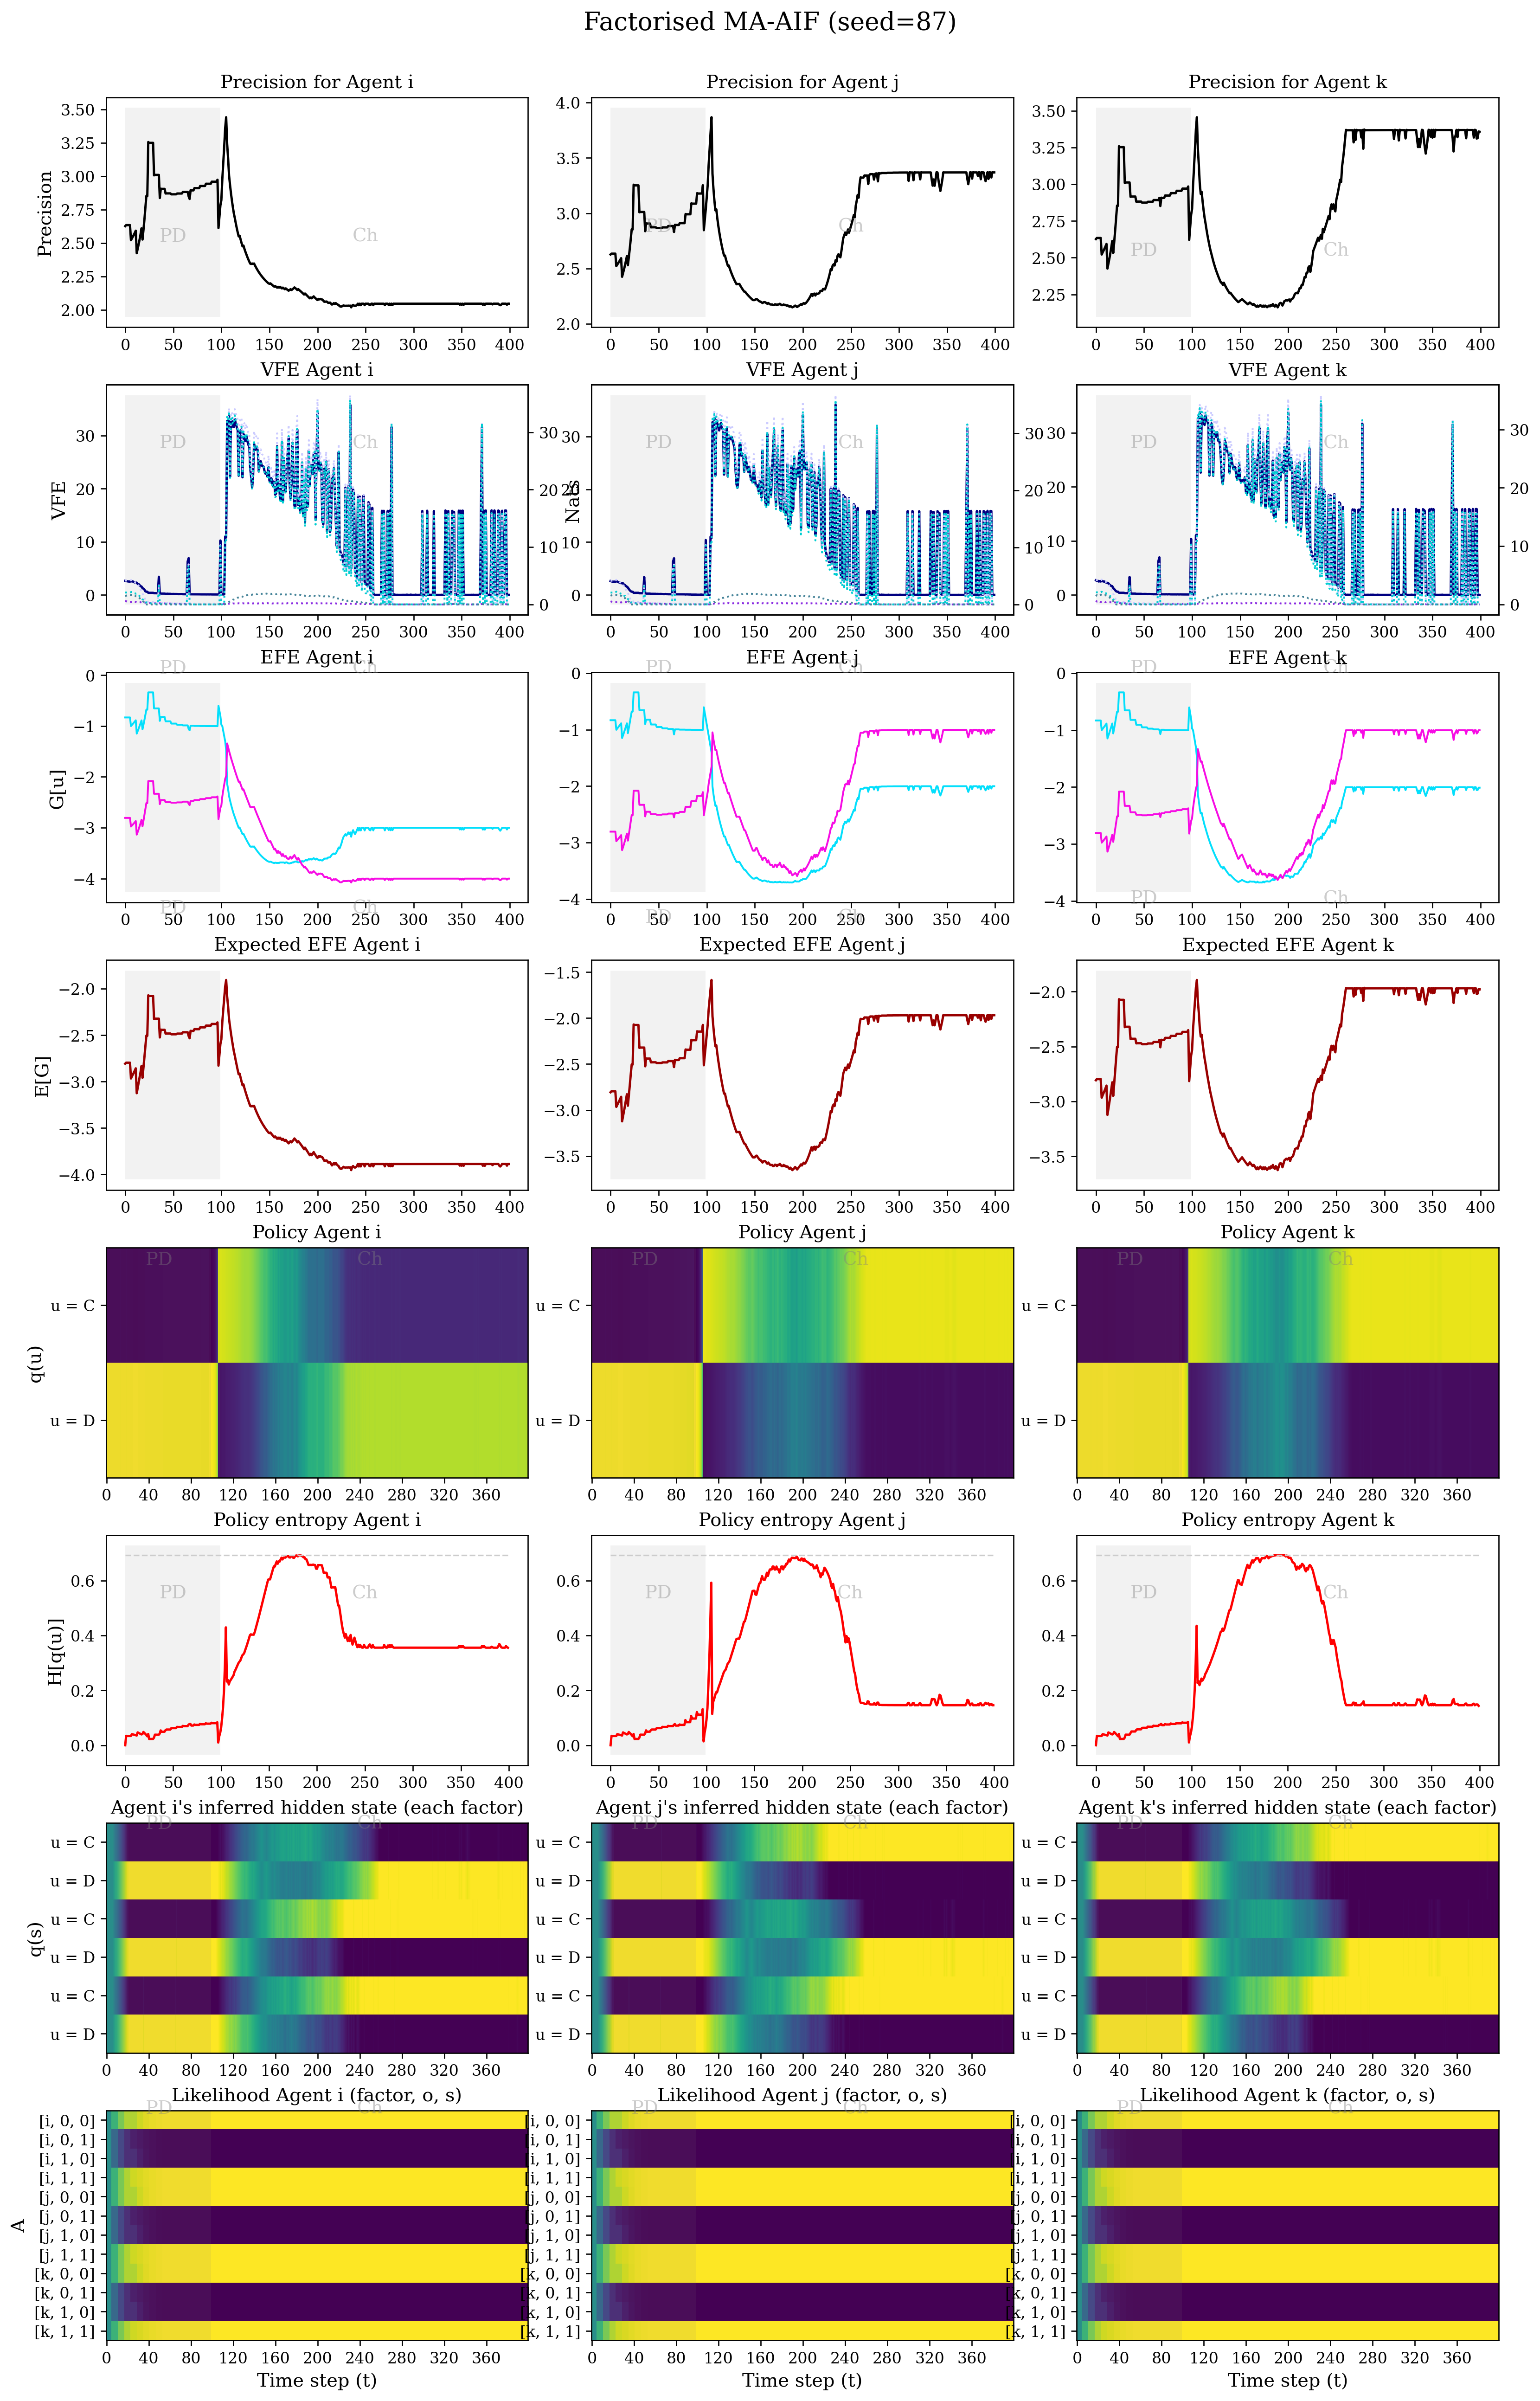

In [3]:
import matplotlib.pyplot as plt

import utils.plotting

utils.plotting.DPI = 120
utils.plotting.SHOW_LEGEND = False
utils.plotting.ONLY_LEFT_Y_LABEL = True
utils.plotting.TIGHT_LAYOUT = True

plot_configs = utils.plotting.make_default_config(variables_history)

utils.plotting.plot(
    plot_configs=plot_configs, 
    game_transitions=game_transitions,
    num_players=num_players, 
    suptitle=(
        f'Factorised MA-AIF (seed={ig.seed})'
    ),
    figsize=(14, 22),
    # t_min=140, t_max=160,
)

plt.show()

## Plot ensemble timeseries

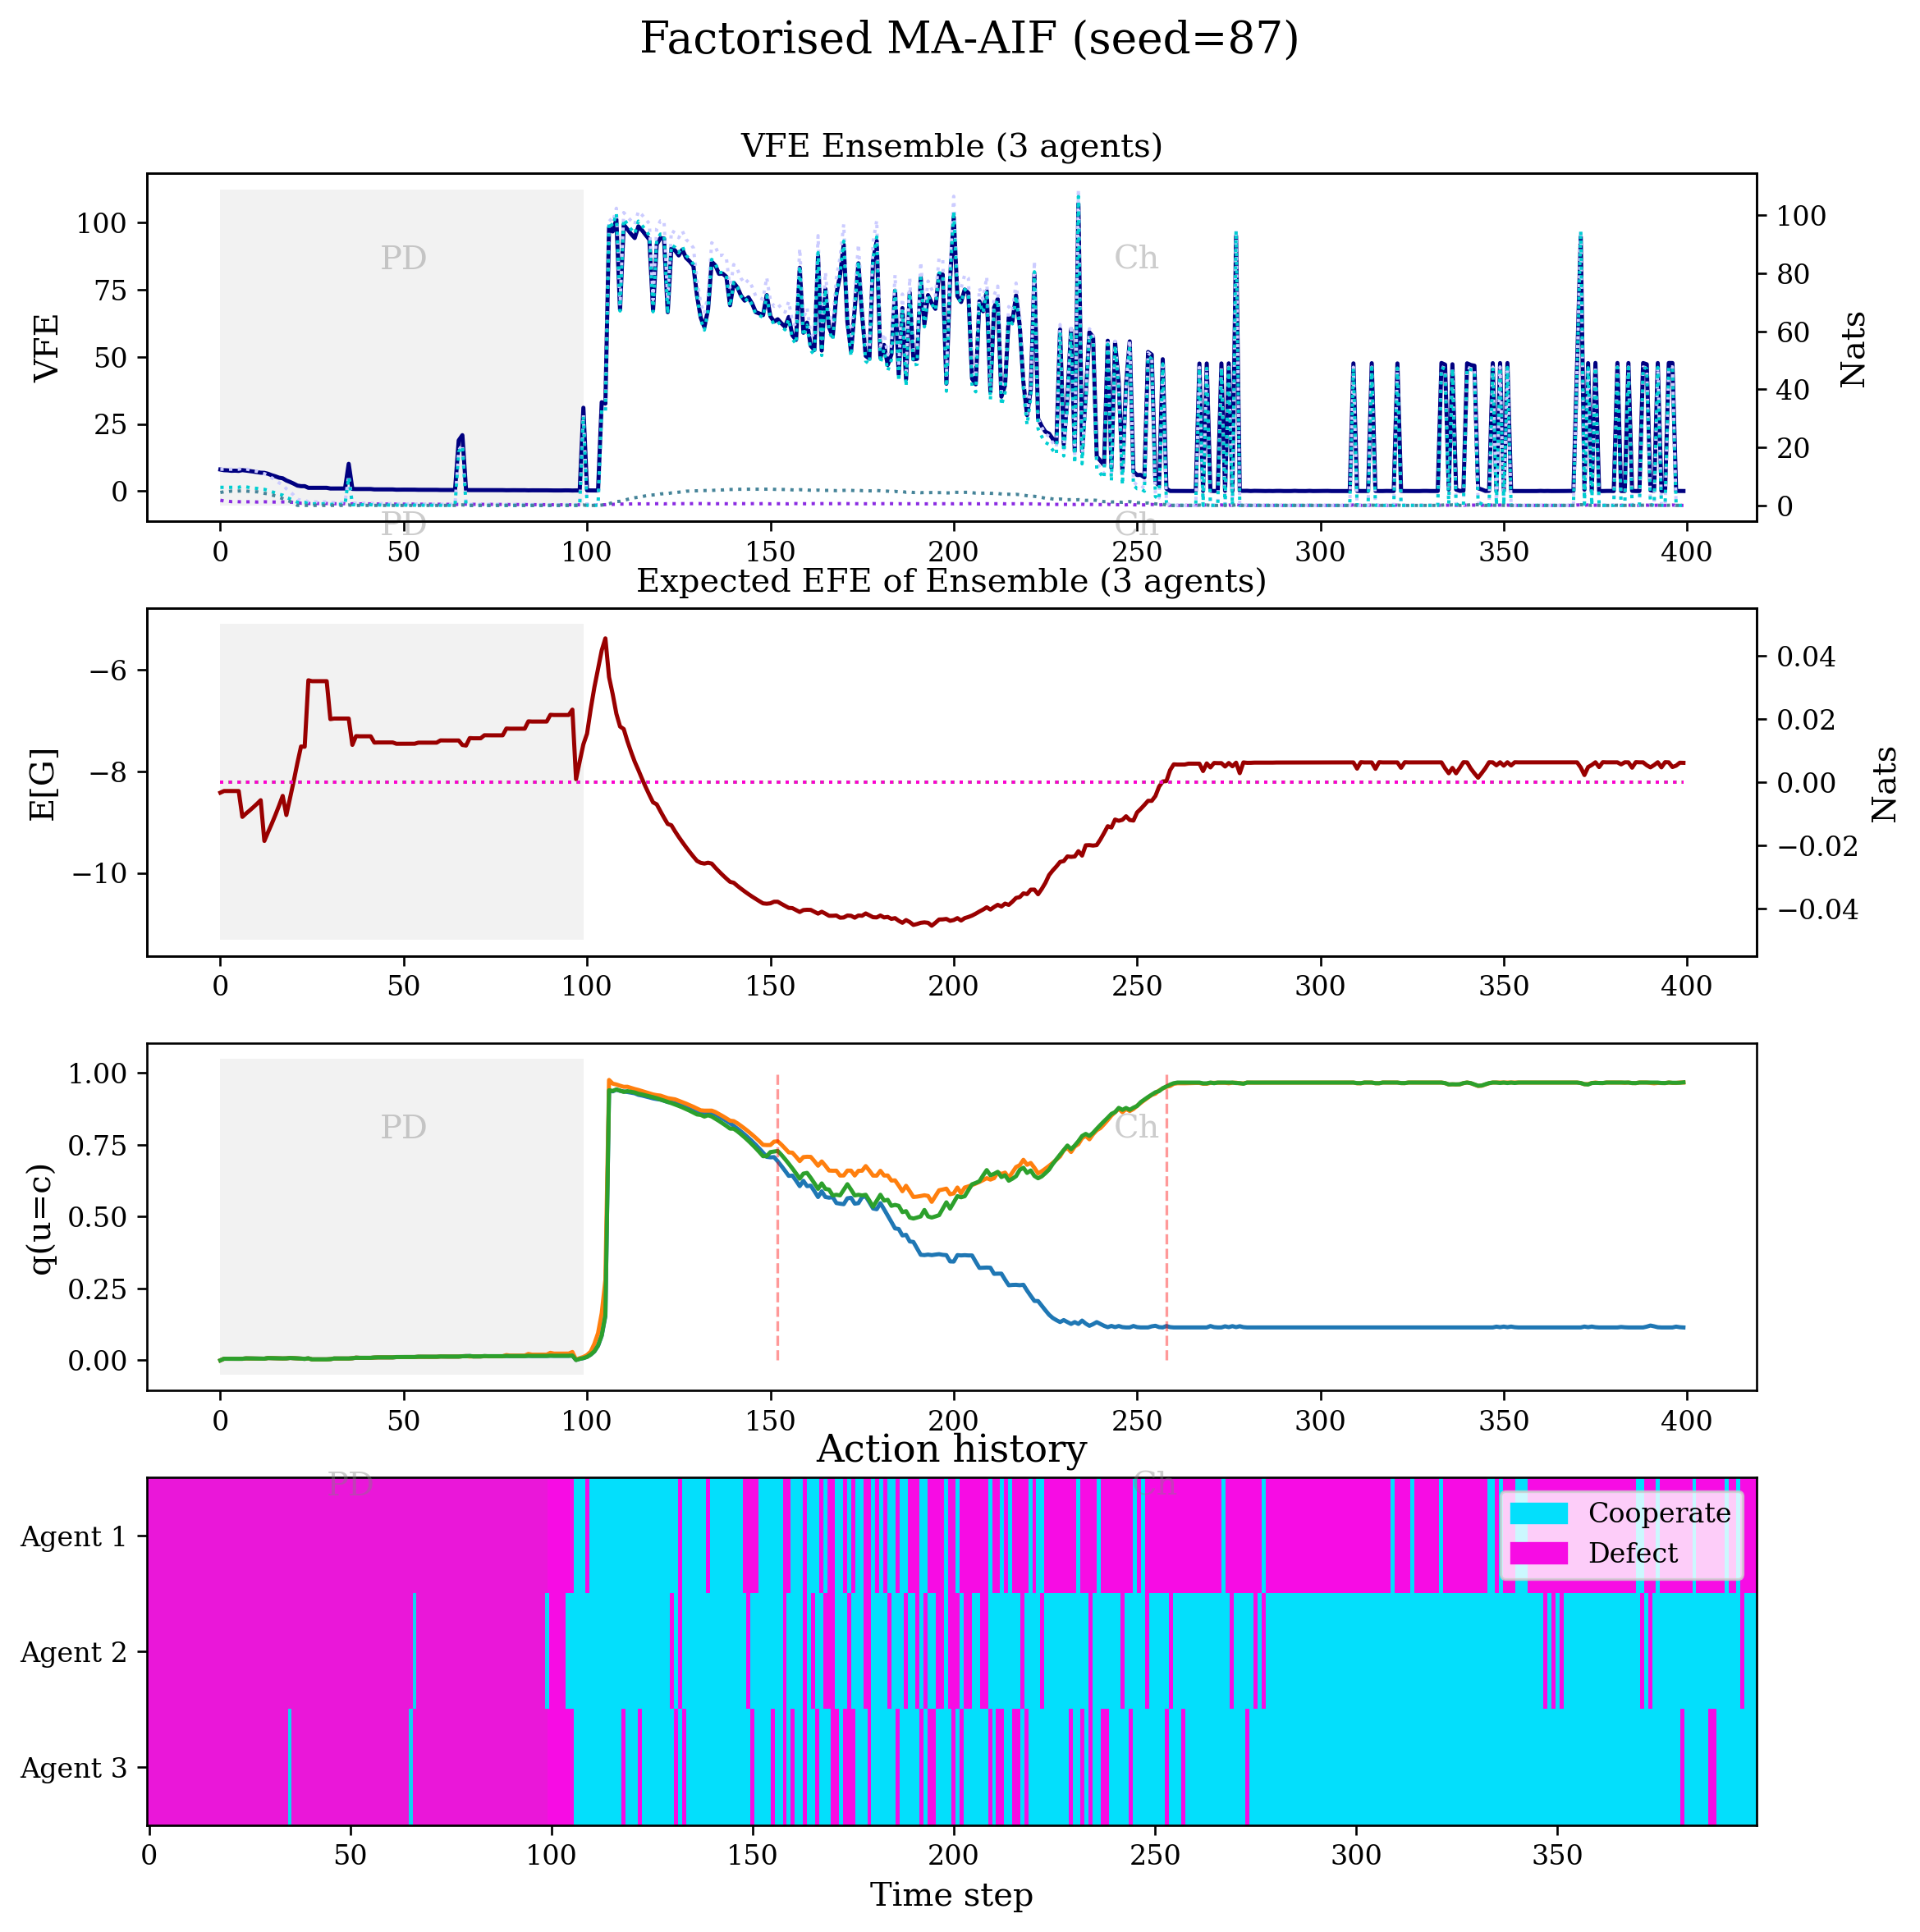

In [4]:
t_min = 0
t_max = None
suptitle = f'Factorised MA-AIF (seed={ig.seed})'

plot_configs = [
    {'plot_fn': utils.plotting.plot_vfe_ensemble,
     'args': (
        np.array(variables_history['VFE']), 
        np.array(variables_history['energy']), 
        np.array(variables_history['complexity']), 
        np.array(variables_history['entropy']), 
        np.array(variables_history['accuracy']), )},
    {'plot_fn': utils.plotting.plot_expected_efe_ensemble,
     'args': (
        np.array(variables_history['q_u']),
        np.array(variables_history['EFE']),
        np.array(variables_history['pragmatic_value']),
        np.array(variables_history['salience']),
        np.array(variables_history['risk']),
        np.array(variables_history['ambiguity']),
        np.array(variables_history['novelty']),)},
    {'plot_fn': utils.plotting.plot_ensemble_policies, 
     'args': (np.array(variables_history['q_u']), game_transitions,)},   
    {'plot_fn': utils.plotting.plot_action_history,
     'args': (np.array(variables_history['u']), num_players, num_actions, )},
]

# Create a figure with subplots for each agent, arranged in a (num_plots)x(num_agents) grid
n_rows = len(plot_configs)
figsize = (10, int(n_rows*2.2)+2)
fig, axes = plt.subplots(n_rows, 1, figsize=figsize, dpi=utils.plotting.DPI)
fig.subplots_adjust(hspace=0.4, wspace=0.1)  # Adjust spacing

for row_idx in range(n_rows):
    ax = axes[row_idx] if n_rows > 1 else axes
    plot_configs[row_idx]['plot_fn'](
        *plot_configs[row_idx]['args'], 
        ax=ax,
        # t_min=t_min, t_max=t_max,  # TODO
    )
    if game_transitions and not t_max:  # TODO: show transitions even if t_max provided
        utils.plotting.highlight_transitions(game_transitions, ax)
    if utils.plotting.TIGHT_LAYOUT and row_idx < n_rows - 1:
        ax.set_xlabel(None)

# Adjust layout for better spacing and overall title
fig.suptitle(suptitle, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make space for the suptitle
if utils.plotting.TIGHT_LAYOUT:
    plt.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()

## State-space analysis

First we plot the trajectory of the agents in the state space (as is). The state space is parameterised by each agent's probability of playing action `cooperate`, i.e.
$$
\times_{i \in \{1, ..., N\}} \; q(u_i = \texttt{c}) \in [0, 1]^N
$$

The triangles on the plot are where all agents play a pure strategy, with
* `pink`: all agents play `defect` with probability 1
* `red`: one of the agents plays `cooperate` w.p. 1, the rest play `defect` w.p. 1
* `orange`: two of the agents play `cooperate` w.p. 1, the other plays `defect` w.p. 1
* `green`: all agents play `cooperate` w.p. 1

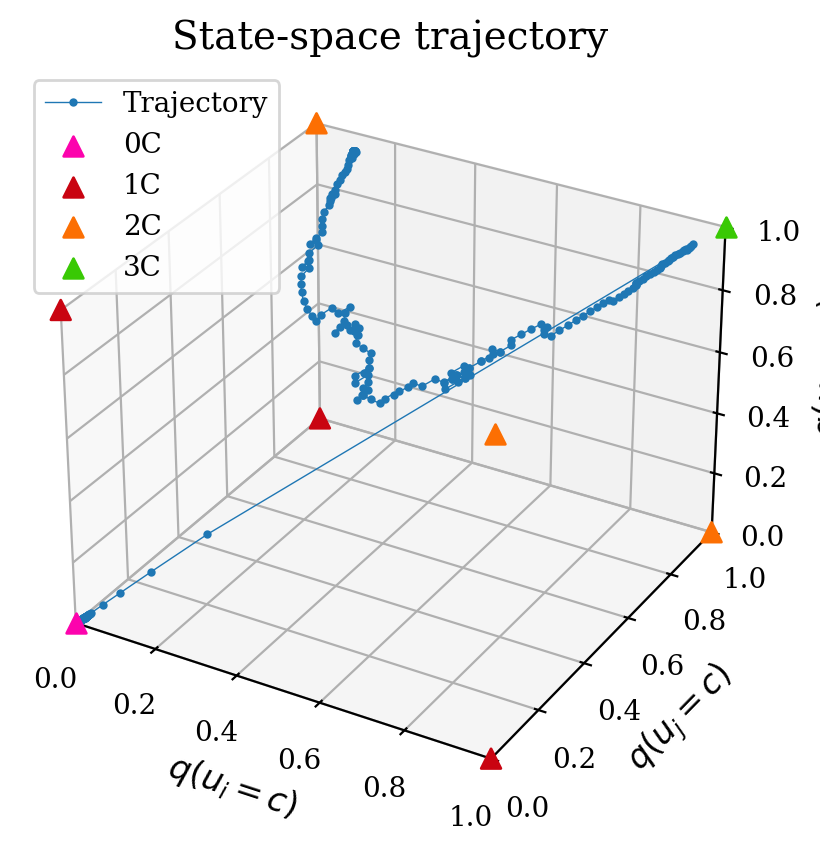

In [5]:
q_u_hist = np.array(variables_history['q_u'])
utils.plotting.plot_state_space_trajectory(q_u_hist[:, :, 0], legend=True)

Since the state space is symmetric under permutations of the agents, we need a "canonical" trajectory to transform towards. 
We do this by finding which of the orange vertices the trajectory gets closest to (at which the symmetry is "most broken").
If the closest one is the "canonical" orange vertex, we do nothing.
If the closest one is the other orange vertex, we permute the agents to transform the trajectory towards the "canonical" orange vertex.

Permuting agents: (2, 1, 0)


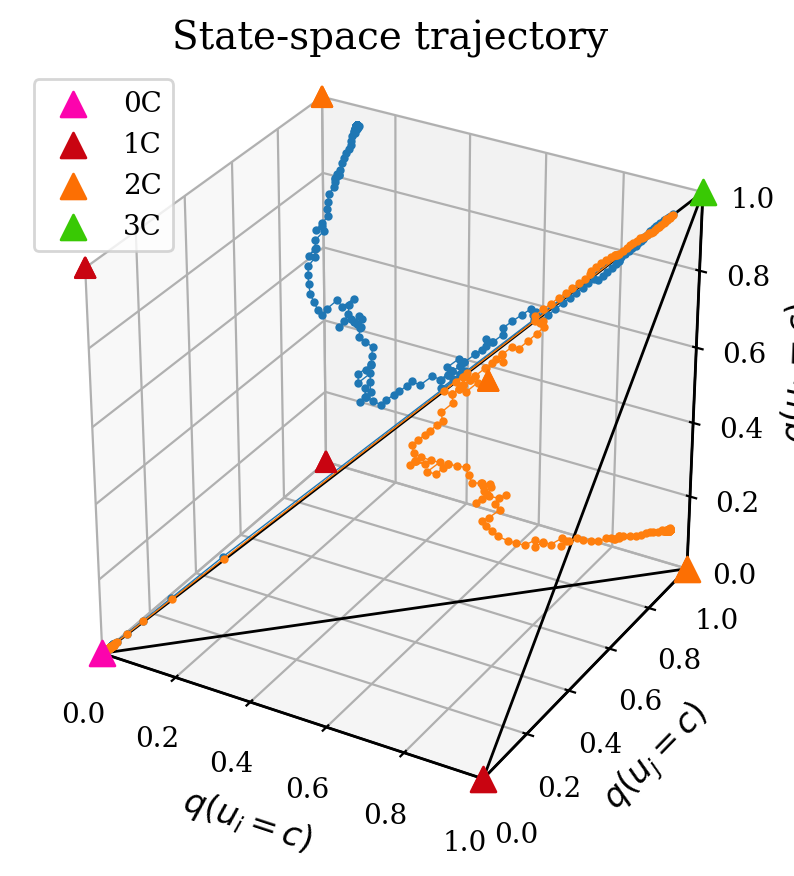

In [7]:
import utils.timeseries

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

utils.plotting.plot_reference_hull(ax, face_alphas=[0.]*5)
# ax.view_init(30, 45)  # set elevation, azimuth, roll

utils.plotting.plot_state_space_trajectory(q_u_hist[:, :, 0], ax)

trajectory = utils.timeseries.permute_agents(q_u_hist[:, :, 0])
utils.plotting.plot_state_space_trajectory(np.array(trajectory), ax)

plt.show()

## Other stuff

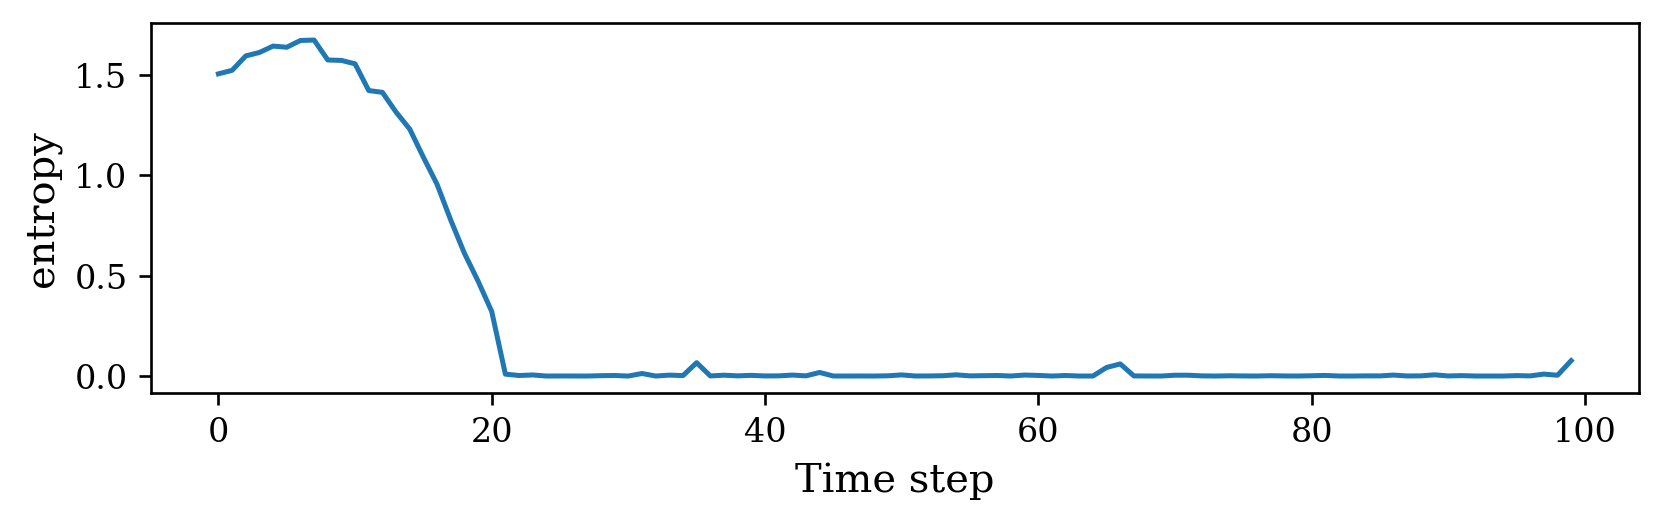

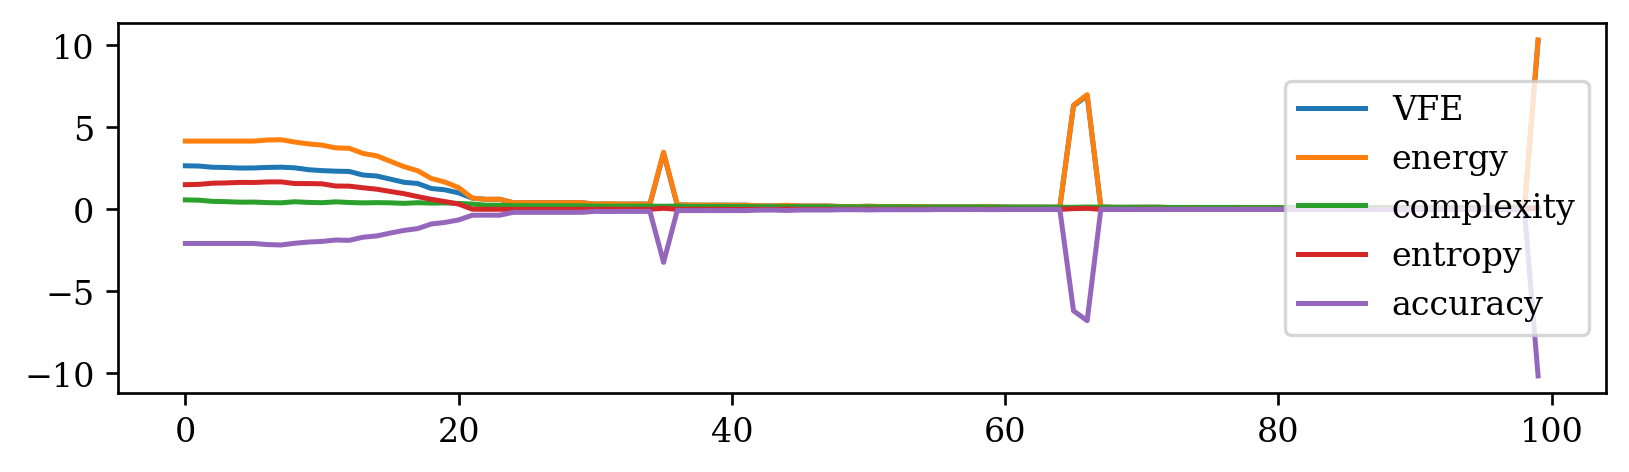

In [8]:
varname = 'entropy'
fig = plt.figure(figsize=(8, 2), dpi=utils.plotting.DPI)
plt.plot(np.array(variables_history[varname])[:100, 0].sum(axis=1), label=varname)
plt.xlabel('Time step')
plt.ylabel(varname)
plt.show()

fig = plt.figure(figsize=(8, 2), dpi=utils.plotting.DPI)
for varname in ['VFE', 'energy', 'complexity', 'entropy', 'accuracy']:
    plt.plot(np.array(variables_history[varname])[:100, 0].sum(axis=1), label=varname)
    # plt.show()
plt.legend()
plt.show()

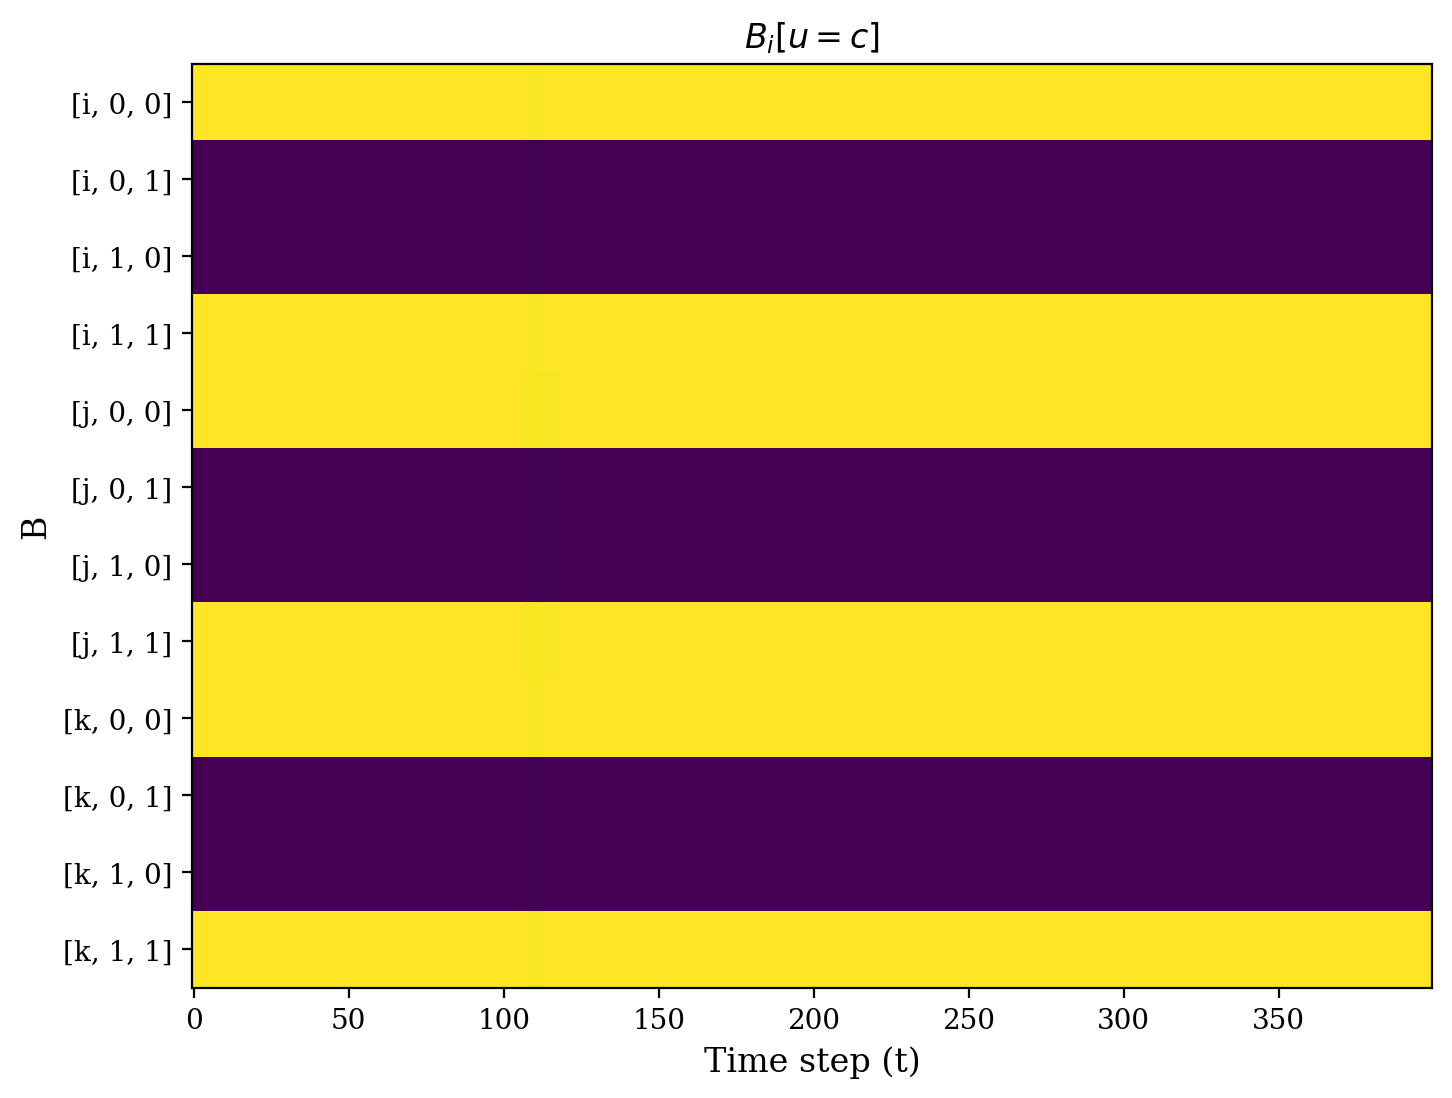

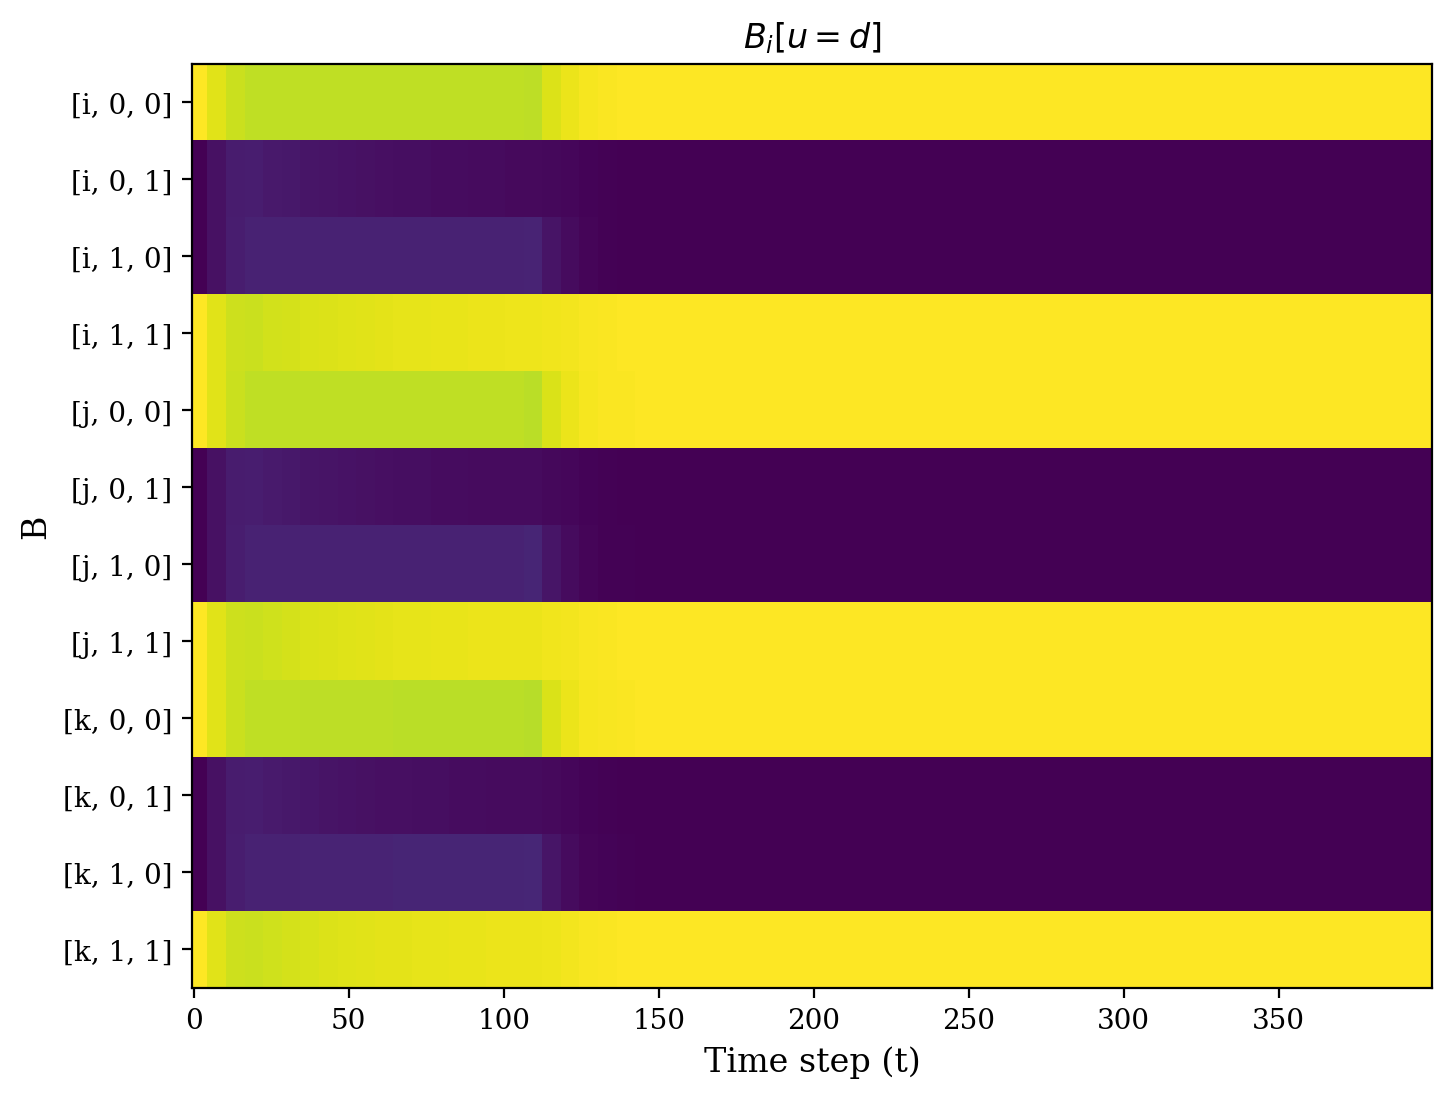

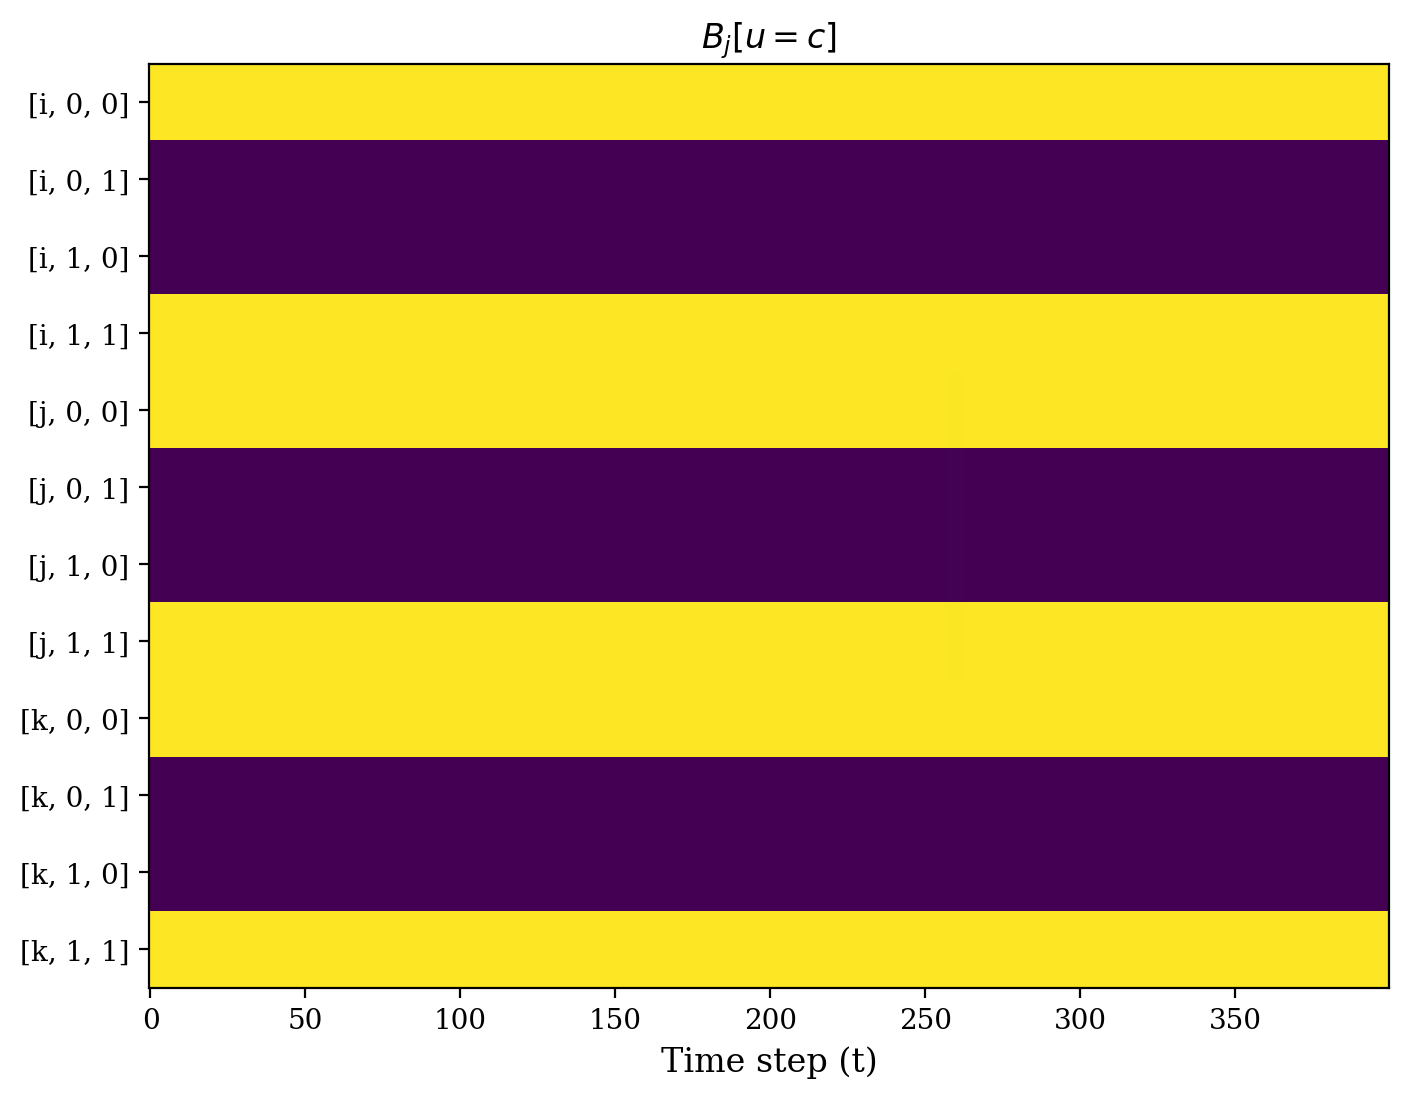

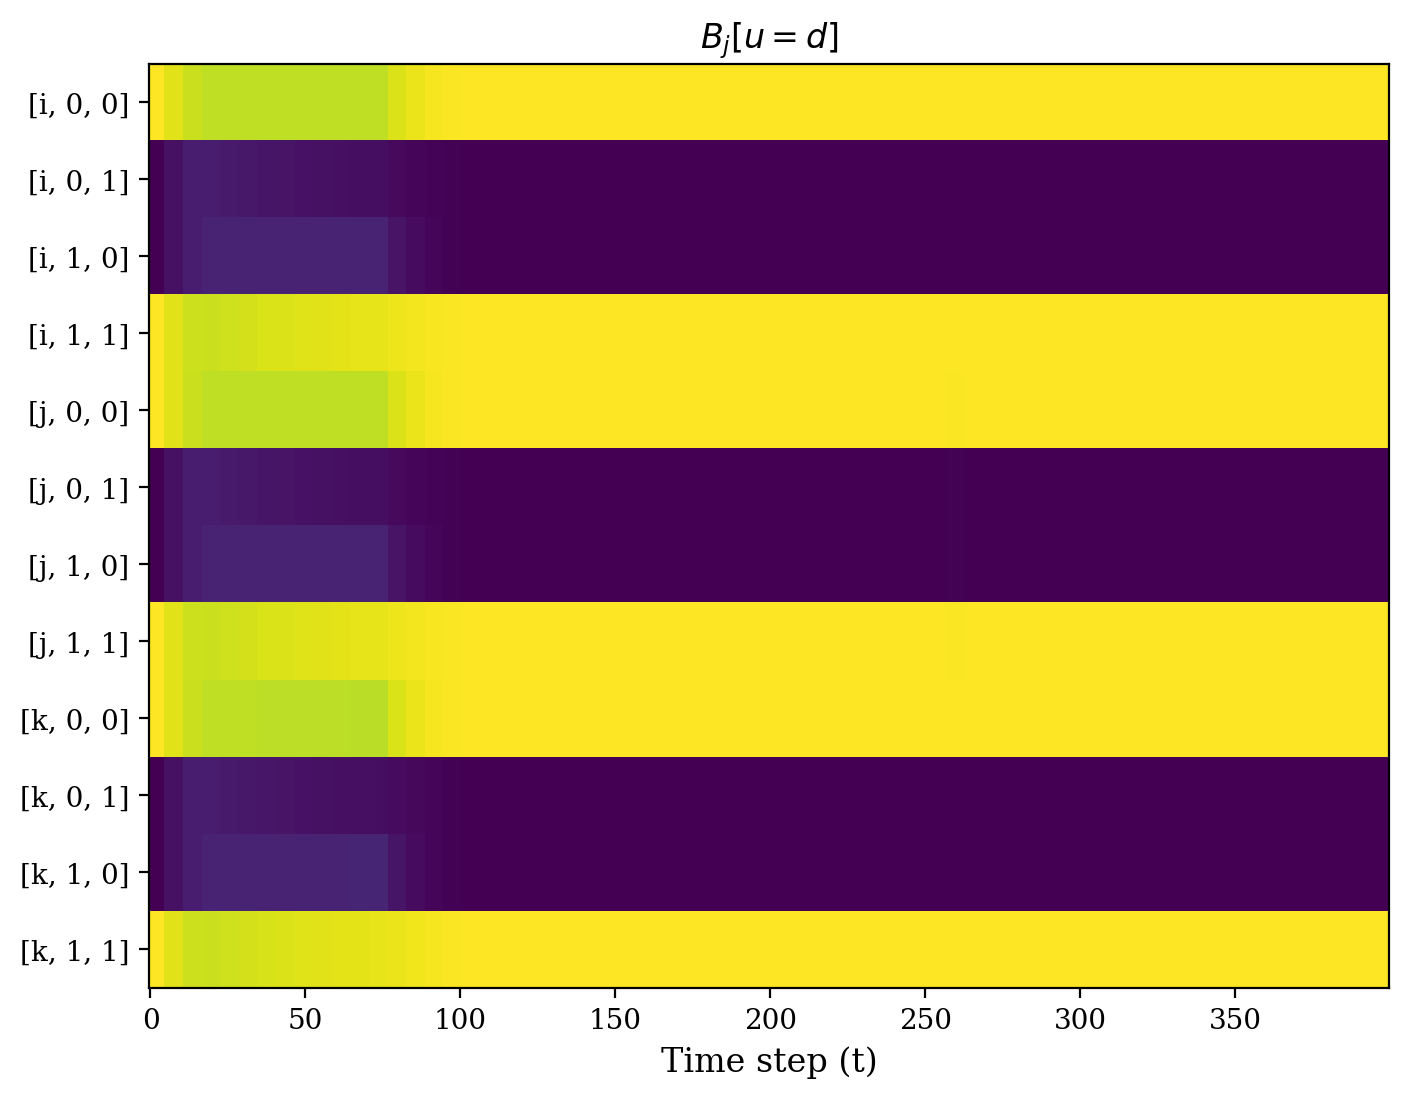

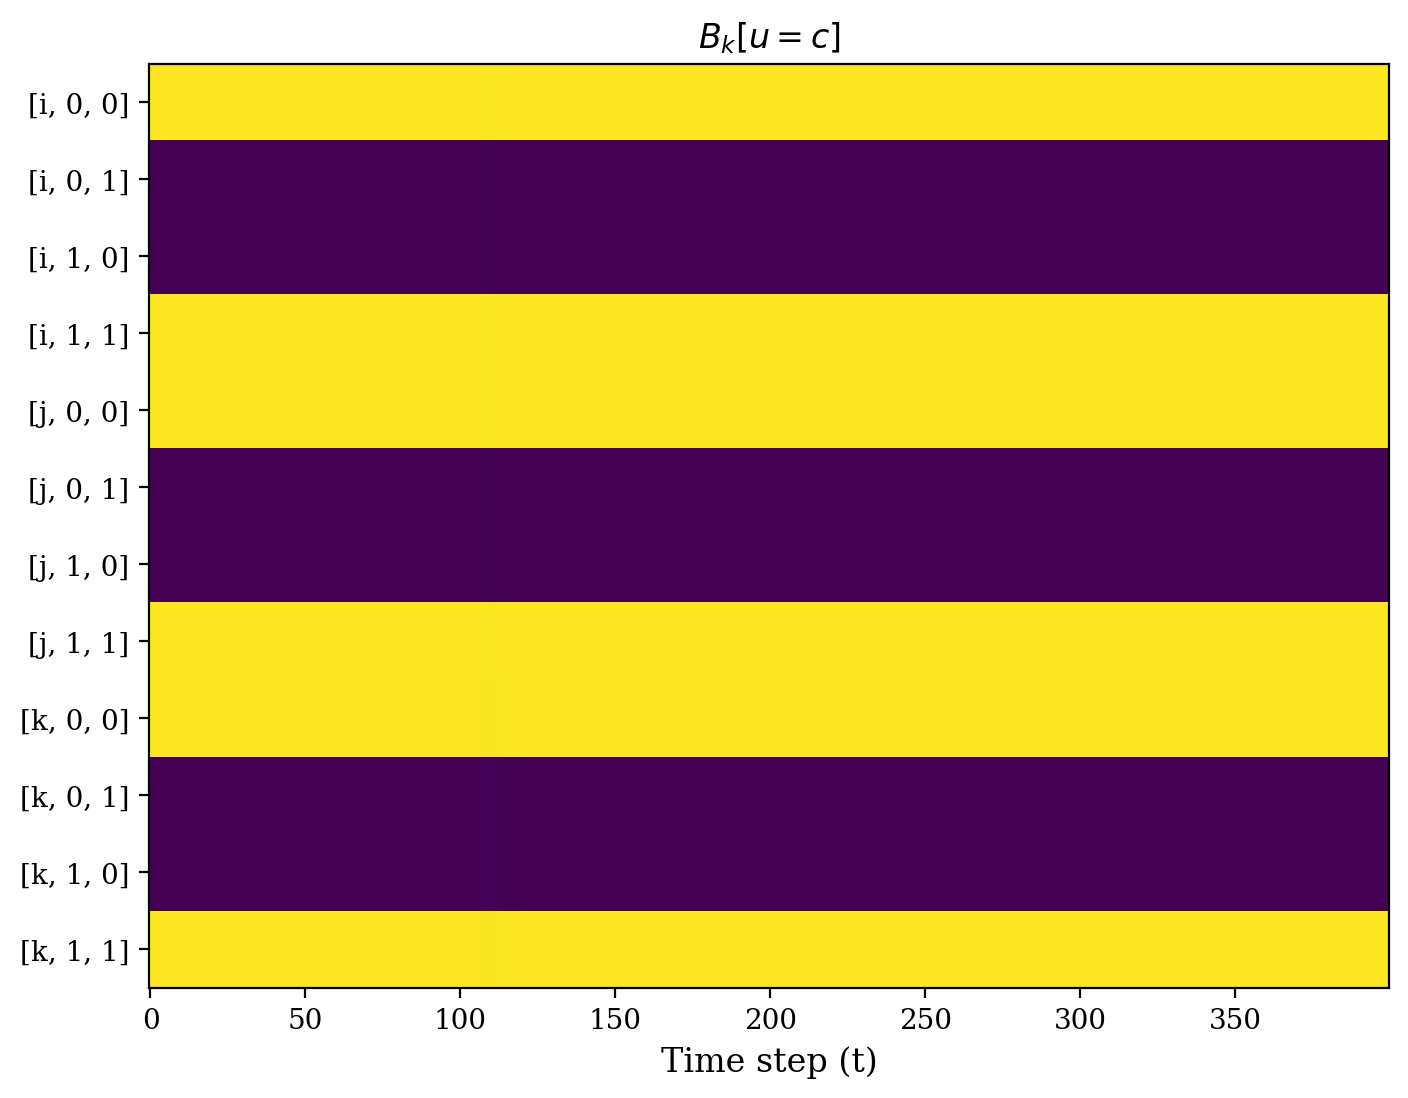

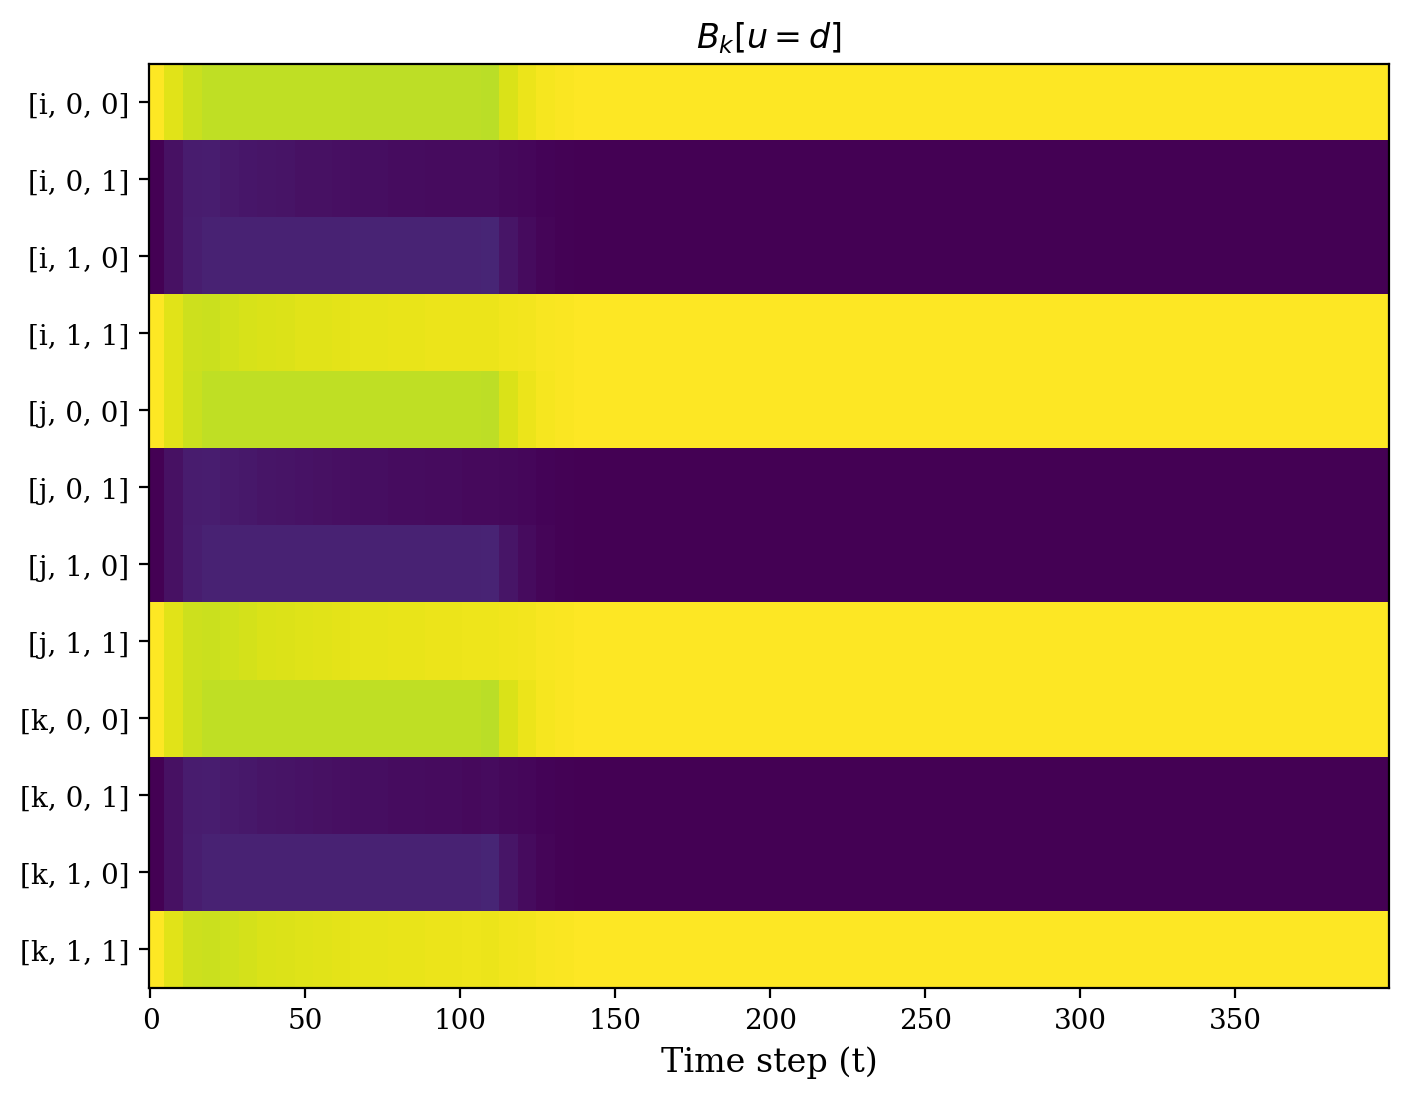

In [9]:
label_font_size = 12
ZOOMED_X_TICK_INTERVAL = 50
ONLY_LEFT_Y_LABEL = utils.plotting.ONLY_LEFT_Y_LABEL

def plot_B(B_history, i, t_min=0, t_max=None):

    t_max = B_history.shape[0] if t_max is None else t_max
    num_players = B_history.shape[1]
    num_actions = B_history.shape[-1]

    labels = [f'[{chr(105+j)}, {o}, {s}]' 
        for j in range(num_players) 
        for o in range(num_actions) 
        for s in range(num_actions)]

    data_per_factor_and_action = [
        B_history[t_min:t_max, i, :, u].reshape((t_max - t_min), -1).T
        for u in range(num_actions)
    ]

    for u_idx, data in enumerate(data_per_factor_and_action):
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        cax = ax.imshow(
            data,
            # vmin=0, vmax=1,
            origin='upper', 
            aspect='auto', 
            interpolation='nearest'
        )

        ax.set_title(f'$B_{chr(105+i)}[u={chr(99+u_idx)}]$', fontsize=label_font_size)
        ax.set_xlabel('Time step (t)', fontsize=label_font_size)
        ax.set_xticks(range(0, t_max-t_min, ZOOMED_X_TICK_INTERVAL))
        ax.set_xticklabels(range(t_min, t_max, ZOOMED_X_TICK_INTERVAL))
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
        if not ONLY_LEFT_Y_LABEL or (ONLY_LEFT_Y_LABEL and i == 0):
            ax.set_ylabel('B', fontsize=label_font_size)

        plt.show()


B_history = np.array(variables_history['B'])
for i in range(num_players):
    plot_B(B_history, i)

## Old plots

In [9]:
# from matplotlib.lines import Line2D

# A_JOINT_COLORS = [  # (o_i, o_j, o_k)
#     '#ff0000',      # CCC
#     '#00ff00',      # CCD
#     '#0000ff',      # CDC
#     '#ff00ff',      # DCC
#     '#00ffff',      # DCD
#     '#ffff00',      # CDC
#     '#800000',      # CDD
#     '#008080',      # DDC
# ]
# markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'x']
# line_styles = ['--', '-.', ':', (0, (3, 5, 1, 5)), (0, (5, 10)), (0, (5, 1)), (0, (1, 1)), '-']

# # when num_players = 3, A_joint_hist shape: (T, num_players, num_actions, num_actions, num_actions, num_actions, num_actions, num_actions)
# #   i.e. for each agent and time step, the joint value of (o_i, o_j, o_k, s_i, s_j, s_k) is stored
# A_joint_hist = np.array(variables_history['A_joint'])
# for i in range(num_players):
#     plt.figure(figsize=(14, 4), dpi=120)
#     flattened_array = A_joint_hist[:, i].flatten(order='C').reshape(A_joint_hist.shape[0], -1)
#     for series_idx in range(flattened_array.shape[1]):
#         bin_value = str(bin(series_idx)).strip('0b').zfill(2*num_players)
#         plt.plot(
#             flattened_array[:, series_idx], 
#             color=A_JOINT_COLORS[series_idx // (num_actions**num_players)], 
#             alpha=1,
#             linewidth=1,
#             linestyle=line_styles[series_idx % (num_actions**num_players)],
#         )
    
#     plt.title(f'Joint observation likelihood model "A_joint" (Agent {i+1})')
#     plt.xlabel('Time step')
#     plt.ylabel('Pseudocount')
#     ax = plt.gca()
#     utils.plotting.highlight_transitions(game_transitions, ax)

#     # Create legend showing only colors
#     legend_elements = [Line2D([0], [0], color=color, lw=2) for color in A_JOINT_COLORS]
#     legend_labels = ['CCC', 'CCD', 'CDC', 'CDD', 'DCC', 'DCD', 'DDC', 'DDD']
#     plt.legend(legend_elements, legend_labels, title='Color Legend')

#     plt.show()